In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numpy import cos,sin,sqrt
from multiprocessing import Pool,Process, Array
import pybinding as pb
from pybinding.repository import group6_tmd
import tbmodels
%matplotlib inline


/Users/Yaroslav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:

py_model = pb.Model(group6_tmd.monolayer_3band("MoS2"), pb.translational_symmetry())
a1,a2=py_model.lattice.vectors
k1,k2=py_model.lattice.reciprocal_vectors()

# Tight-binding Hamiltonian

In [145]:
def hamiltonian(vec):
    a1=3.190/10
    e1=0.683;e2=1.707;
    t0=-0.146;t1=-0.114;t2=0.506;t11=0.085;t12=0.162;t22=0.073
    r0=0.060 ;r1=-0.236;r2=0.067;r11=0.016;r12=0.087;r22=0.000
    u0=-0.038;u1=0.046 ;u2=0.001;u11=0.266;u12=-0.176;u22=-0.150
    SOC=0.073
    a=vec[0]*a1/2;b=vec[1]*a1*sqrt(3)/2
    
    V0=e1+2*t0*(2*cos(a)*cos(b)+cos(2*a))+2*r0*(2*cos(3*a)*cos(b)+cos(2*b))+2*u0*(2*cos(2*a)*cos(2*b)+cos(4*a))
    
    V1_Re=-2*sqrt(3)*t2*sin(a)*sin(b)+2*(r1+r2)*sin(3*a)*sin(b)-2*sqrt(3)*u2*sin(2*a)*sin(2*b)
    
    V1_Im=2*t1*sin(a)*(2*cos(a)+cos(b))+2*(r1-r2)*sin(3*a)*cos(b)+2*u1*sin(2*a)*(2*cos(2*a)+cos(2*b))
    
    V2_Re=2*t2*(cos(2*a)-cos(a)*cos(b))-2/sqrt(3)*(r1+r2)*(cos(3*a)*cos(b)-cos(2*b))+2*u2*(cos(4*a)-cos(2*a)*cos(2*b))
    
    V2_Im=2*sqrt(3)*t1*cos(a)*sin(b)+2/sqrt(3)*sin(b)*(r1-r2)*(cos(3*a)+2*cos(b))+2*sqrt(3)*u1*cos(2*a)*sin(2*b)
    
    V11=e2+(t11+3*t22)*cos(a)*cos(b)+2*t11*cos(2*a)+4*r11*cos(3*a)*cos(b)+2*(r11+sqrt(3)*r12)*cos(2*b)+(u11+3*u22)*cos(2*a)*cos(2*b)+2*u11*cos(4*a)
    
    V12_Re=sqrt(3)*(t22-t11)*sin(a)*sin(b)+4*r12*sin(3*a)*sin(b)+sqrt(3)*(u22-u11)*sin(2*a)*sin(2*b)
    
    V12_Im=4*t12*sin(a)*(cos(a)-cos(b))+4*u12*sin(2*a)*(cos(2*a)-cos(2*b))
    
    V22=e2+(3*t11+t22)*cos(a)*cos(b)+2*t22*cos(2*a)+2*r11*(2*cos(3*a)*cos(b)+cos(2*b))+2/sqrt(3)*r12*(4*cos(3*a)*cos(b)-cos(2*b))+(3*u11+u22)*cos(2*a)*cos(2*b)+2*u22*cos(4*a)
    H=np.array([[V0 ,V1_Re+1j*V1_Im  ,V2_Re+1j*V2_Im],
                [V1_Re-1j*V1_Im,V11,V12_Re+1j*V12_Im],
                [V2_Re-1j*V2_Im,V12_Re-1j*V12_Im,V22]])
    Lz=np.array([[0.,0.,0.],[0.,0.,2j],[0.,-2j,0.]])
    return np.block([[H+SOC/2.*Lz,np.zeros((3,3))],[np.zeros((3,3)),H-SOC/2.*Lz]])
    #return H

In [146]:
k_points = py_model.lattice.brillouin_zone()
G = np.array([0, 0])
K = k_points[3]
M = (k_points[3] + k_points[2]) / 2
K_ = k_points[2]
kpoints=[];N1=80;N2=int(N1/2);N3=int(np.sqrt(N1**2+N2**2))
for i in range(N1):
    kpoints.append(i*K/N1+(N1-i)*G/N1)
for i in range(N2):
    kpoints.append(i*M/N2+(N2-i)*K/N2)
for i in range(N2):
    kpoints.append(i*K_/N2+(N2-i)*M/N2)
for i in range(N3):
    kpoints.append(i*G/N3+(N3-i)*K_/N3)
kpoints=np.array(kpoints)

In [147]:
 py_model.lattice.brillouin_zone()

[array([ -6.56550221, -11.37178326]),
 array([  6.56550221, -11.37178326]),
 array([13.13100429,  0.        ]),
 array([ 6.56550221, 11.37178326]),
 array([-6.56550221, 11.37178326]),
 array([-13.13100429,   0.        ])]

(-1.5, 4)

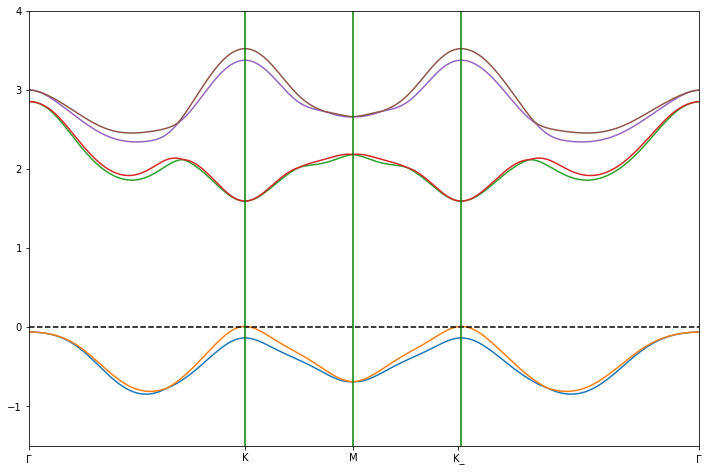

In [148]:
E_line=[]
norb=6;
for i in range(kpoints.shape[0]):
    e,d=np.linalg.eigh(hamiltonian(kpoints[i]))
    E_line.append(e);
E_line=np.array(E_line)

plt.figure(figsize=(12,8))
for i in range(norb):
    plt.plot(E_line[:,i],'-')
plt.plot(np.linspace(0,300),np.zeros(50),'--',color='black')
plt.plot(np.ones(50)*(N1),np.linspace(-6,5),'-',color='green')
plt.plot(np.ones(50)*(N1+N2),np.linspace(-6,5),'-',color='green')
plt.plot(np.ones(50)*(N1+2*N2),np.linspace(-6,5),'-',color='green')
plt.xticks([0,N1,N1+N2,N1+2*N2-1,N1+2*N2+N3-1],['$\Gamma$','K','M','K_','$\Gamma$'])
plt.xlim([0.,N1+2*N2+N3-1])
plt.ylim([-1.5,4])

# Bethe-Salpeter Equation

## Constants and Keldysh potential

In [149]:
epsilon=1
h=4.135667516*10**(-15)/(2*np.pi)
c=299792458*10**9
alpha=0.65 #nm
r0=2*np.pi*alpha #nm
const=4*np.pi*h*c/137
e_shift=0
def Keldysh_potential(q):
    q=np.linalg.norm(q)
    if q==0:
        return 0
    else:
        return const/(2*q*(1+r0*q))

## Parameters

In [150]:
N=20 # k-points grid
V=N**2*np.sqrt(3)/2*(3.190/10)**2
v=[0,1] # valence bands
c=[2,3] # conduction bands
number_of_processes=16# number of parallel processes
nv=len(v);nc=len(c)
k_norm=22.74356651
norb=6

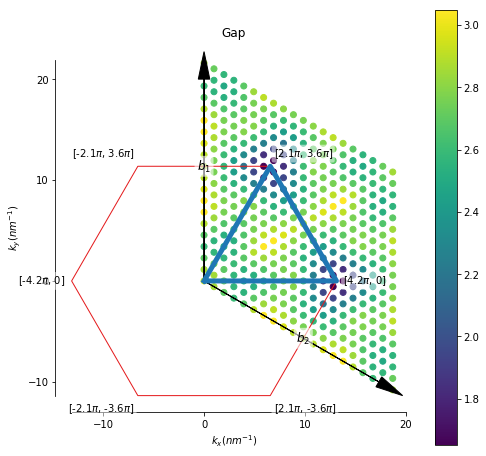

In [151]:
k1,k2=py_model.lattice.reciprocal_vectors()
E=np.zeros((N,N,norb));K=np.zeros((N,N,3));D=np.zeros((N,N,norb,norb),dtype=np.complex)
for i,j in product(range(N),range(N)):
    e,d=np.linalg.eigh(hamiltonian(i*k1/N+j*k2/N))
    E[i,j]=e;D[i,j]=d
    K[i,j]=i*k1/N+j*k2/N
K=K.reshape((N**2,3))
E=E.reshape((N**2,norb))
D=D.reshape((N**2,norb,norb))
plt.figure(figsize=(8,8))
py_model.lattice.plot_brillouin_zone()
plt.title('Gap')
plt.scatter(K[:,0].ravel(),K[:,1].ravel(),c=(E[:,2].ravel()-E[:,1].ravel()))
plt.plot(kpoints[:,0].ravel(),kpoints[:,1].ravel(),lw=5)
plt.colorbar()

In [152]:
def calculate_I(param):
    b1,b2,k1=param
    return [np.sum(D[k1,:,b1].conj()*D[k2,:,b2]) for k2 in range(N**2)]
pool=Pool(processes=number_of_processes)
Iv=np.array(pool.map(calculate_I, [(b1,b2,k1) for b1,b2,k1 in product(v,v,range(N**2))])).reshape(nv,nv,N**2,N**2)
Ic=np.array(pool.map(calculate_I, [(b1,b2,k1) for b1,b2,k1 in product(c,c,range(N**2))])).reshape(nc,nc,N**2,N**2)
pool.terminate()

In [153]:

def calculate_kinetic(param):
    b1,b2=param
    return [E[k,b1]-E[k,b2] for k in range(N**2)]
pool=Pool(processes=number_of_processes)


H_kin=np.array(pool.map(calculate_kinetic,[(b1,b2) for b1,b2 in product(c,v)]),dtype=np.complex)
H=np.diag(H_kin.reshape(nc,nv,N**2).ravel())
pool.terminate()

In [154]:
def calculate_interaction(param):
    c1,v1,k1,c2,v2=param
    return [-Keldysh_potential(K[k1]-K[k2])*Ic[c2,c1,k2,k1].conj()*Iv[c2,c1,k2,k1]/V for k2 in range(N**2)]
pool=Pool(processes=number_of_processes)
Int_param=[(c1,v1,k1,c2,v2) for c1,v1,k1,c2,v2 in product(range(nc),range(nv),range(N**2),range(nc),range(nv))]
H+=np.array(pool.map(calculate_interaction,Int_param),dtype=np.complex).reshape(nc*nv*N**2,nc*nv*N**2)
pool.terminate()

In [155]:
EH,DH=np.linalg.eig(H)
DH=DH[:,np.argsort(EH)];EH=np.sort(EH)

### Exciton binding energy

In [156]:
E_gap=np.min(E[:,2].ravel()-E[:,1].ravel())+e_shift
Eb=(np.min(E[:,2].ravel()-E[:,1].ravel())+e_shift-EH[0]).real
print('Exciton binding energy:'+str(np.round(Eb,4))+'eV')
print('Gap energy:'+str(np.round(E_gap,4))+'eV')

Exciton binding energy:0.3031eV
Gap energy:1.6506eV


### Exciton Spectrum

In [157]:
nw=200;NH=EH.size
omega=np.linspace(1.5,3,nw);eta=0.02
sigma=np.zeros(nw,dtype=np.complex)
def gradient_hamiltonian_X(k):
    eps = np.sqrt(np.finfo(np.float).eps)
    return (hamiltonian(k+[0,eps,0])-hamiltonian(k))/eps
I=np.zeros((N**2,nc,nv),dtype=np.complex)
for k,i,j in product(range(N**2),range(nc),range(nv)):
    grad=gradient_hamiltonian_X(K[k])
    for a,b in product(range(norb),range(norb)):
        I[k,i,j]+=D[k,j,a].conj()*D[k,i,b]*grad[a,b]
I=I.reshape(NH)
for w in range(nw):
    for M in range(NH):
        sigma[w]+=np.sum(np.abs(DH[M]*I)**2)/(omega[w]+1j*eta-EH[M])

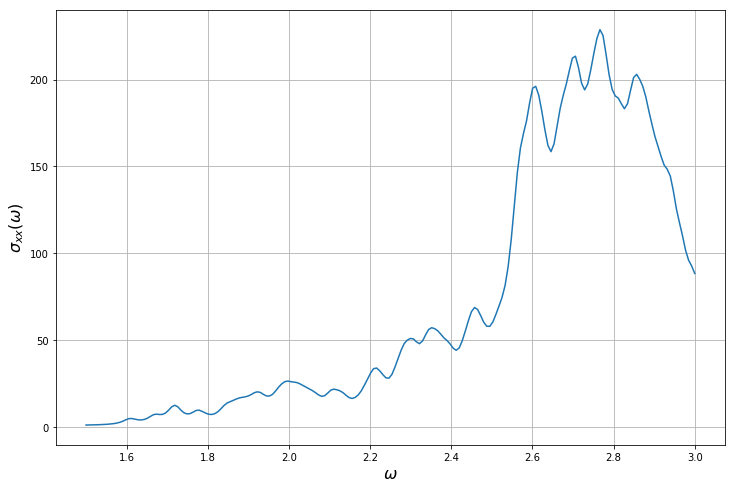

In [158]:
plt.figure(figsize=(12,8))
plt.plot(omega,-sigma.imag)
plt.ylabel('$\sigma_{xx}(\omega)$',fontsize=16)
plt.xlabel('$\omega$',fontsize=16)
plt.grid()

(1.5, 3)

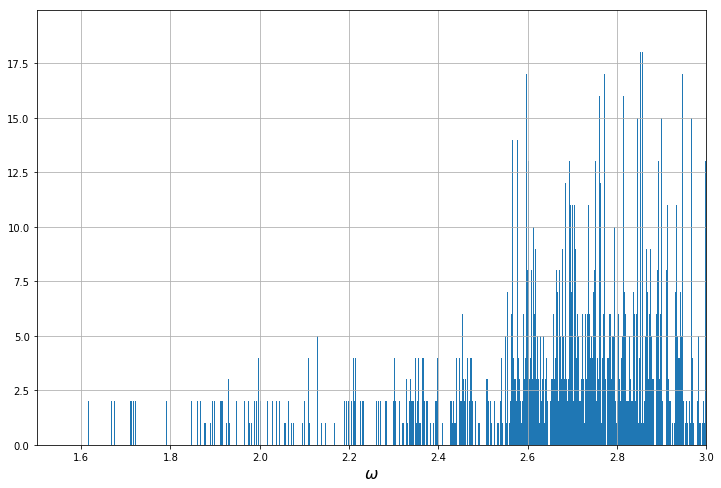

In [159]:
plt.figure(figsize=(12,8))
plt.hist(EH.real,bins=1000)
plt.xlabel('$\omega$',fontsize=16)
plt.grid()
plt.xlim([1.5,3])

### Exciton wave-function

In [176]:
def plot_wave_function(wave_number):
    wave=np.abs(DH[:,wave_number]**2.).reshape(nc,nv,N**2)
    indx=[]
    for k in kpoints:
        indx.append(np.argmin(np.linalg.norm(K[:,:2]-k,axis=1)))

    wave=wave[:,:,indx];wave=wave/np.max(wave)
    
    E_line=[]
    for i in range(kpoints.shape[0]):
        e,d=np.linalg.eigh(hamiltonian(kpoints[i]))
        E_line.append(e);
    E_line=np.array(E_line)

    plt.figure(figsize=(12,8))
    for i in range(norb):
        plt.plot(E_line[:,i],'--',color='black')
    line=np.arange(kpoints.shape[0])
    for i in range(nc):
        for j in range(nv):
            plt.scatter(line,E_line[:,c[i]],s=100*np.sum(wave[i,:,:],axis=0).ravel())
            plt.scatter(line,E_line[:,v[j]],s=100*np.sum(wave[:,j,:],axis=0).ravel())
    plt.plot(np.linspace(0,300),np.zeros(50),'--',color='black')
    plt.plot(np.ones(50)*(N1),np.linspace(-6,5),'-',color='green')
    plt.plot(np.ones(50)*(N1+N2),np.linspace(-6,5),'-',color='green')
    plt.plot(np.ones(50)*(N1+2*N2),np.linspace(-6,5),'-',color='green')
    plt.xticks([0,N1,N1+N2,N1+2*N2-1,N1+2*N2+N3-1],['$\Gamma$','K','M','K_','$\Gamma$'])
    plt.xlim([0.,N1+2*N2+N3-1])
    plt.ylim([-1.5,4])
    
def plot_wave_function_reciprocal(wave_number):
    wave=np.abs(DH[:,wave_number].reshape(nc,nv,N**2,))**2
    
    wave=np.sum(wave,axis=(0,1))
    wave=wave/np.max(wave)
    plt.figure(figsize=(8,8))
    py_model.lattice.plot_brillouin_zone()
    plt.scatter(K[:,0].ravel(),K[:,1].ravel(),c=wave)
    plt.clim([0,np.max(wave)])
    plt.colorbar()


In [177]:
EH[:10].real

array([1.34745791, 1.3474625 , 1.37248762, 1.37249733, 1.60673126,
       1.60673209, 1.61729139, 1.61731241, 1.66775783, 1.66775785])

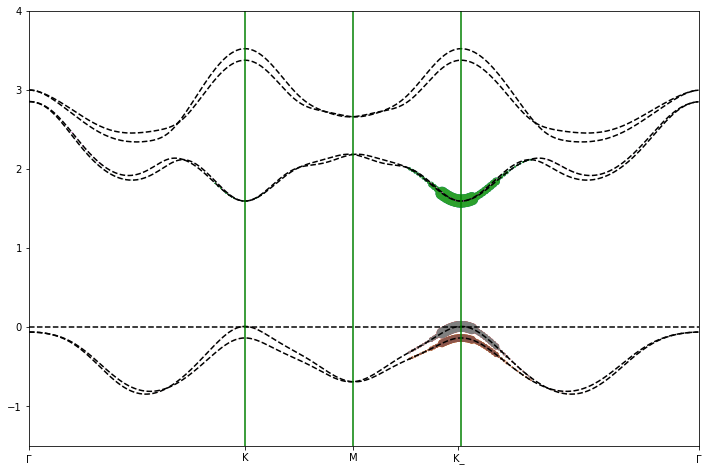

In [178]:
plot_wave_function(0)

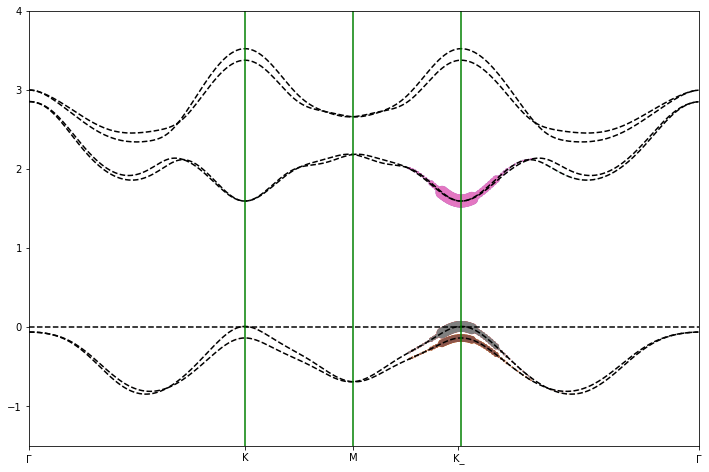

In [179]:
plot_wave_function(2)

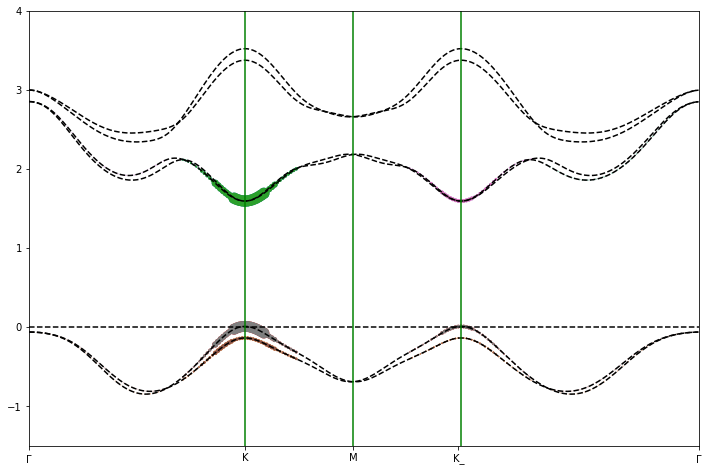

In [180]:
plot_wave_function(4)

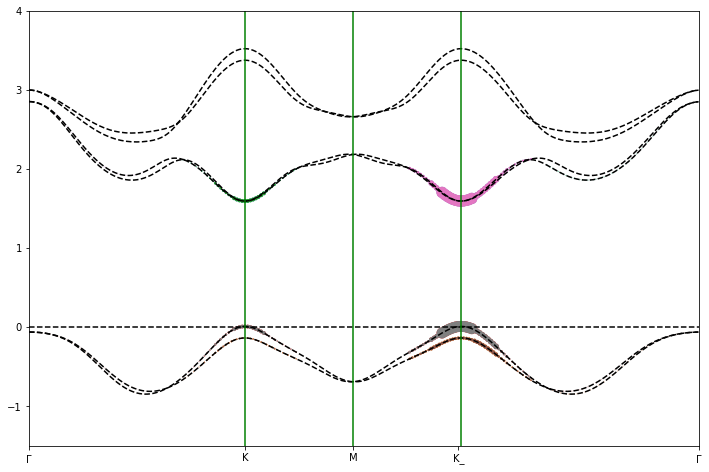

In [181]:
plot_wave_function(6)